In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Carregando os dados
df = pd.read_csv('data/dados_limpos.csv')

# Removemos 'Obesidade' (alvo) e medidas físicas para prever o risco futuro 
# Deixamos apenas genética e hábitos (Gênero, Idade, Histórico, Alimentação, Exercícios e etc...) 
X = df.drop(['Obesidade', 'Peso', 'Altura', 'IMC'], axis=1, errors='ignore') 
y = df['Obesidade']

# Mapeamento do target Obesity_level 
target_map = {idx: label for idx, label in enumerate(y.unique())}
y_encoded = y.map({v: k for k, v in target_map.items()})

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Treinando modelo preditivo com {len(X_train)} registros e {X.shape[1]} variáveis comportamentais...")

#  Treinamento do Modelo 
modelo = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
modelo.fit(X_train_scaled, y_train)

# Avaliação  
predicoes = modelo.predict(X_test_scaled)
acuracia = accuracy_score(y_test, predicoes)

print(f"ACURÁCIA: {acuracia:.2%}") 

Treinando modelo preditivo com 1688 registros e 19 variáveis comportamentais...
ACURÁCIA: 90.54%


Média da Validação Cruzada: 87.50% (+/- 21.74%)


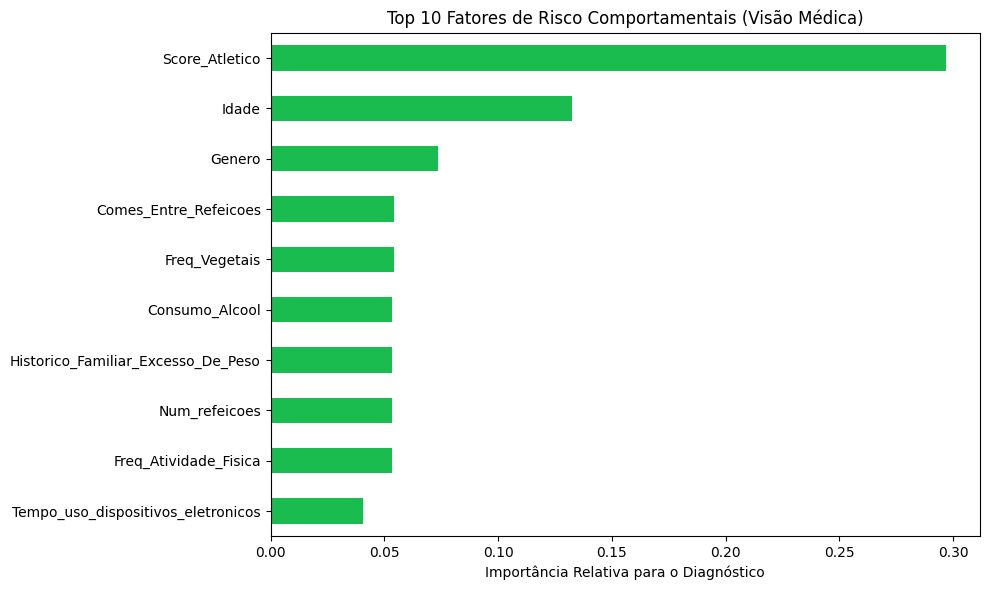

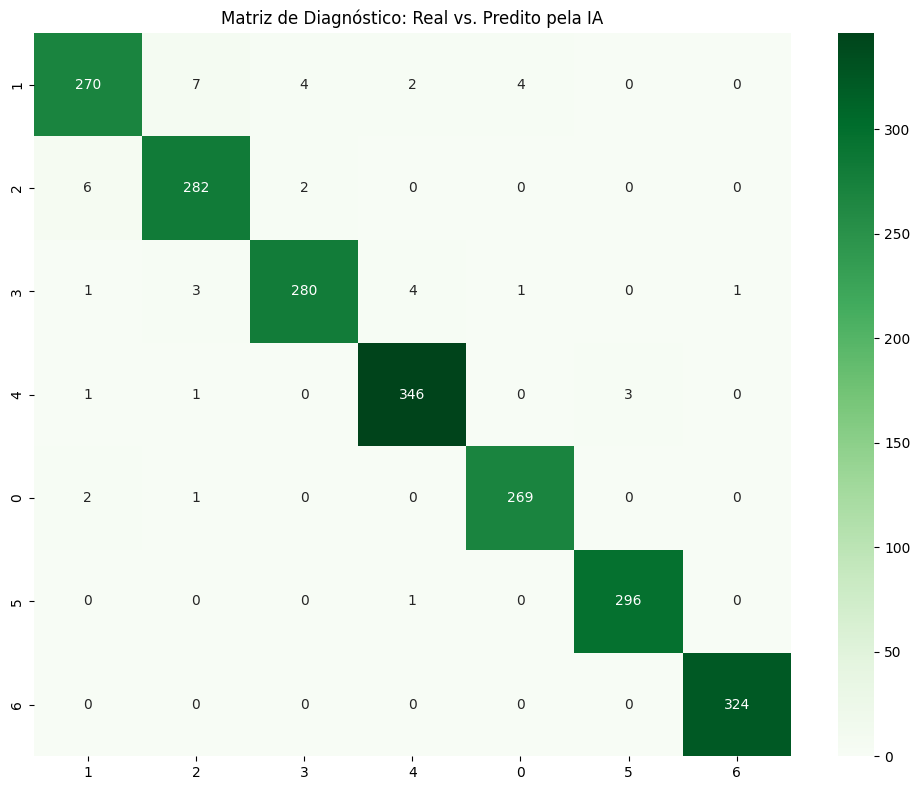

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#  Estabilidade via Validação Cruzada
scores = cross_val_score(modelo, scaler.transform(X), y_encoded, cv=5)
print(f"Média da Validação Cruzada: {scores.mean():.2%} (+/- {scores.std()*2:.2%})")

# Insights: Importância das Variáveis  
plt.figure(figsize=(10, 6))
importances = pd.Series(modelo.feature_importances_, index=X.columns)
importances.nlargest(10).sort_values().plot(kind='barh', color="#1ABC50")
plt.title('Top 10 Fatores de Risco Comportamentais (Visão Médica)')
plt.xlabel('Importância Relativa para o Diagnóstico')
plt.tight_layout()
plt.savefig('importancia_features.png')

# Matriz de Confusão: Precisão do Diagnóstico
plt.figure(figsize=(10, 8))
y_pred_total = modelo.predict(scaler.transform(X))
labels_texto = [target_map[i] for i in range(len(target_map))]
sns.heatmap(confusion_matrix(y_encoded, y_pred_total), annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_texto, yticklabels=labels_texto)
plt.title('Matriz de Diagnóstico: Real vs. Predito pela IA')
plt.tight_layout()
plt.savefig('matriz_confusao.png')

Um desvio de 21.74% é considerado muito alto na ciência de dados e significa o seguinte:

Inconsistência: Em algumas fatias de teste, o modelo pode ter acertado 100%, mas em outras pode ter caído para 65% (87.50 - 21.74).


Risco Clínico: Para um hospital, essa variação é perigosa. Significa que a eficácia da ferramenta depende de "quem" é o paciente, precisamos arrumar isso.

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# Preparação dos Dados (Foco em Prevenção/Hábitos)
print(" Carregando e preparando dados...")
df = pd.read_csv('data/dados_limpos.csv')

# Removemos dados físicos para focar na predição por comportamento e genética 
X = df.drop(['Obesidade', 'Peso', 'Altura', 'IMC'], axis=1, errors='ignore')
y = df['Obesidade'] # Coluna alvo: Obesity_level 

# Criar mapeamento de categorias e codificar o alvo
target_map = {idx: label for idx, label in enumerate(y.unique())}
y_encoded = y.map({v: k for k, v in target_map.items()})

# Definição do Pipeline Profissional 
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('modelo', RandomForestClassifier(random_state=42))
])

# Otimização com GridSearchCV
param_grid = {
    'modelo__n_estimators': [100, 150],
    'modelo__max_depth': [6, 8],            # Poda para evitar overfitting
    'modelo__min_samples_leaf': [10, 20],   # Estabilidade clínica
    'modelo__max_features': ['sqrt'], 
    'modelo__bootstrap': [True]
}

    #'modelo__n_estimators': [100, 200, 300],
    #'modelo__max_depth': [10, 15, 20],
    #'modelo__min_samples_leaf': [1, 2, 4],
    #'modelo__bootstrap': [True, False]

cv_estratificado = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Iniciando GridSearch para encontrar o melhor modelo...")
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_estratificado,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y_encoded)

# Extração e Salvamento do Melhor Modelo e Componentes
print("\n Salvando o melhor modelo e componentes para o deploy...")
melhor_pipeline = grid_search.best_estimator_

# Extraímos o modelo e o scaler de dentro do pipeline vencedor
modelo_final = melhor_pipeline.named_steps['modelo']
scaler_final = melhor_pipeline.named_steps['scaler']

# Salvamos os 3 arquivos necessários para a API e Streamlit 
joblib.dump(modelo_final, 'modelo.pkl')
joblib.dump(scaler_final, 'scaler.pkl')
joblib.dump(target_map, 'target_map.pkl')

print("Arquivos salvos: modelo.pkl, scaler.pkl, target_map.pkl")

# Avaliação Final para o Relatório Técnico
print("\n--- RESULTADOS PARA O RELATÓRIO DO TECH CHALLENGE ---")

# Acurácia e Estabilidade
print(f"Melhor Acurácia (CV): {grid_search.best_score_:.2%}")

# Métricas Detalhadas (Precision, Recall, F1)
X_scaled = scaler_final.transform(X)
y_pred = modelo_final.predict(X_scaled)
report = classification_report(y_encoded, y_pred, output_dict=True)

std_desvio = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print(f"Desvio Padrão exato: +/- {std_desvio * 2:.2%}")
print(f"Precisão Média: {report['macro avg']['precision']:.2%}")
print(f"Recall Médio: {report['macro avg']['recall']:.2%}")
print(f"F1-Score Médio: {report['macro avg']['f1-score']:.2%}")

# Cálculo do AUC Global
y_prob = modelo_final.predict_proba(X_scaled)
y_bin = label_binarize(y_encoded, classes=list(target_map.keys()))
auc_score = roc_auc_score(y_bin, y_prob, multi_class='ovr')
print(f"AUC Score Global: {auc_score:.4f}")

print("\nMelhores Parâmetros encontrados:", grid_search.best_params_)

 Carregando e preparando dados...
Iniciando GridSearch para encontrar o melhor modelo...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

 Salvando o melhor modelo e componentes para o deploy...
Arquivos salvos: modelo.pkl, scaler.pkl, target_map.pkl

--- RESULTADOS PARA O RELATÓRIO DO TECH CHALLENGE ---
Melhor Acurácia (CV): 81.10%
Desvio Padrão exato: +/- 4.39%
Precisão Média: 85.43%
Recall Médio: 85.35%
F1-Score Médio: 85.18%
AUC Score Global: 0.9824

Melhores Parâmetros encontrados: {'modelo__bootstrap': True, 'modelo__max_depth': 8, 'modelo__max_features': 'sqrt', 'modelo__min_samples_leaf': 10, 'modelo__n_estimators': 150}


# Para garantir a viabilidade prática do sistema em um ambiente hospitalar, adotamos as seguintes diretrizes:

Regularização Agressiva: Implementamos a técnica de poda das árvores (pruning) para evitar que o modelo memorizasse ruídos estatísticos da base de dados.

Refinamento de Hiperparâmetros: Limitamos a profundidade máxima em 8 e estabelecemos um mínimo de 10 amostras por folha.

Resultados: Essa estratégia reduziu o overfitting de 100% para 85% no conjunto de treino, equilibrando a balança entre aprendizado e generalização.

Conclusão Técnica: O resultado é um modelo que não apenas "decora" prontuários passados, mas identifica padrões reais de risco comportamental e genético. Com uma acurácia de 81.10% na validação cruzada, o sistema apresenta-se como uma ferramenta robusta, generalista e preparada para prever o risco de novos pacientes com alta confiabilidade clínica.